# Neural Network Training

In [1]:
import matplotlib.pyplot as plt

import torch.optim as optim
import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LinearRegression, MNIST

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we tune the parameters of a gradient descent algorithm training a neural network. We can train either a linear regression or an MLP or CNN MNIST model. Any optimizer can be used, such as `SGD` or `Adam`, and any parameter can be tuned, such as `lr` or `momentum`. 

Which optimizer to use is specified in the `make_optimizer` argument, and how to update and tune things is specified in the `apply_control` argument

## Hyperparameters

In [2]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 10000  # total timesteps
T0 = 5300  # number of timesteps to just sysid for our methods
reset_every = 2000  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1
initial_lr = 0.2
make_optimizer = lambda model: optim.SGD(model.parameters(), lr=initial_lr)
def apply_control(control, system): system.opt.param_groups[0]['lr'] = initial_lr * (1.3 ** control.item())

make_system = lambda : LinearRegression(make_optimizer, apply_control,
                                        dataset = 'generated', 
                                        eval_every=1, seed=SYSTEM_SEED)

# make_system = lambda : MNIST(make_optimizer, apply_control,
#                              model_type = 'MLP', batch_size = 64,
#                              eval_every=None, seed=SYSTEM_SEED)

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.5

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 4,
    'buffer_maxlen': int(1e6),
    'num_epochs': 200,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 20  # controller memory length (# of w's to use on inference)
hh = 20  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
#     'bounds': (0, 2),
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_sigmoid': True,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
#     'Zero': lambda sys: ConstantController(0, du),
#     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [3]:
def plot_nn(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot system and controller stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'lrs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'train losses', label=method)
        stats.plot(ax[1, 1], 'val losses', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        stats.plot(ax[3, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()
    
    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('lr'); _ax.legend(); ylim(_ax, -1, 2)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('train losses'); _ax.legend(); ylim(_ax, -2, 5)
    _ax = ax[1, 1]; _ax.set_title('val losses'); _ax.legend(); ylim(_ax, -2, 5)
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing Learned Lift
registering running average of costs


  0%|                                                                                                                | 0/10000 [00:00<?, ?it/s]

reset!


 20%|██████████████▍                                                        | 2028/10000 [00:13<00:49, 159.56it/s, control=0.0819, cost=0.0148]

reset!


 40%|████████████████████████████▌                                          | 4019/10000 [00:26<00:38, 157.30it/s, control=-.0842, cost=0.0129]

reset!


 53%|█████████████████████████████████████                                 | 5291/10000 [00:34<00:28, 164.54it/s, control=-.0441, cost=0.00828]

training!
mean loss for past 25 epochs was 2443.134656645879
mean loss for past 25 epochs was 33.179453803524375
mean loss for past 25 epochs was 5.09129451436922
mean loss for past 25 epochs was 0.008199512837454676
mean loss for past 25 epochs was 0.0009596567088738084


 53%|█████████████████████████████████████                                 | 5291/10000 [00:50<00:28, 164.54it/s, control=-.0441, cost=0.00828]

mean loss for past 25 epochs was 0.0020766011497471482
mean loss for past 25 epochs was 0.00024234624055679887
mean loss for past 25 epochs was 0.00022963105060625822


 60%|█████████████████████████████████████████████▋                              | 6006/10000 [01:16<01:37, 40.77it/s, control=0.177, cost=272]

reset!


 80%|████████████████████████████████████████████████████████████▊               | 8006/10000 [02:04<00:47, 42.07it/s, control=0.146, cost=284]

reset!


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [02:53<00:00, 57.60it/s, control=0.0373, cost=0.00828]


<Figure size 640x480 with 0 Axes>

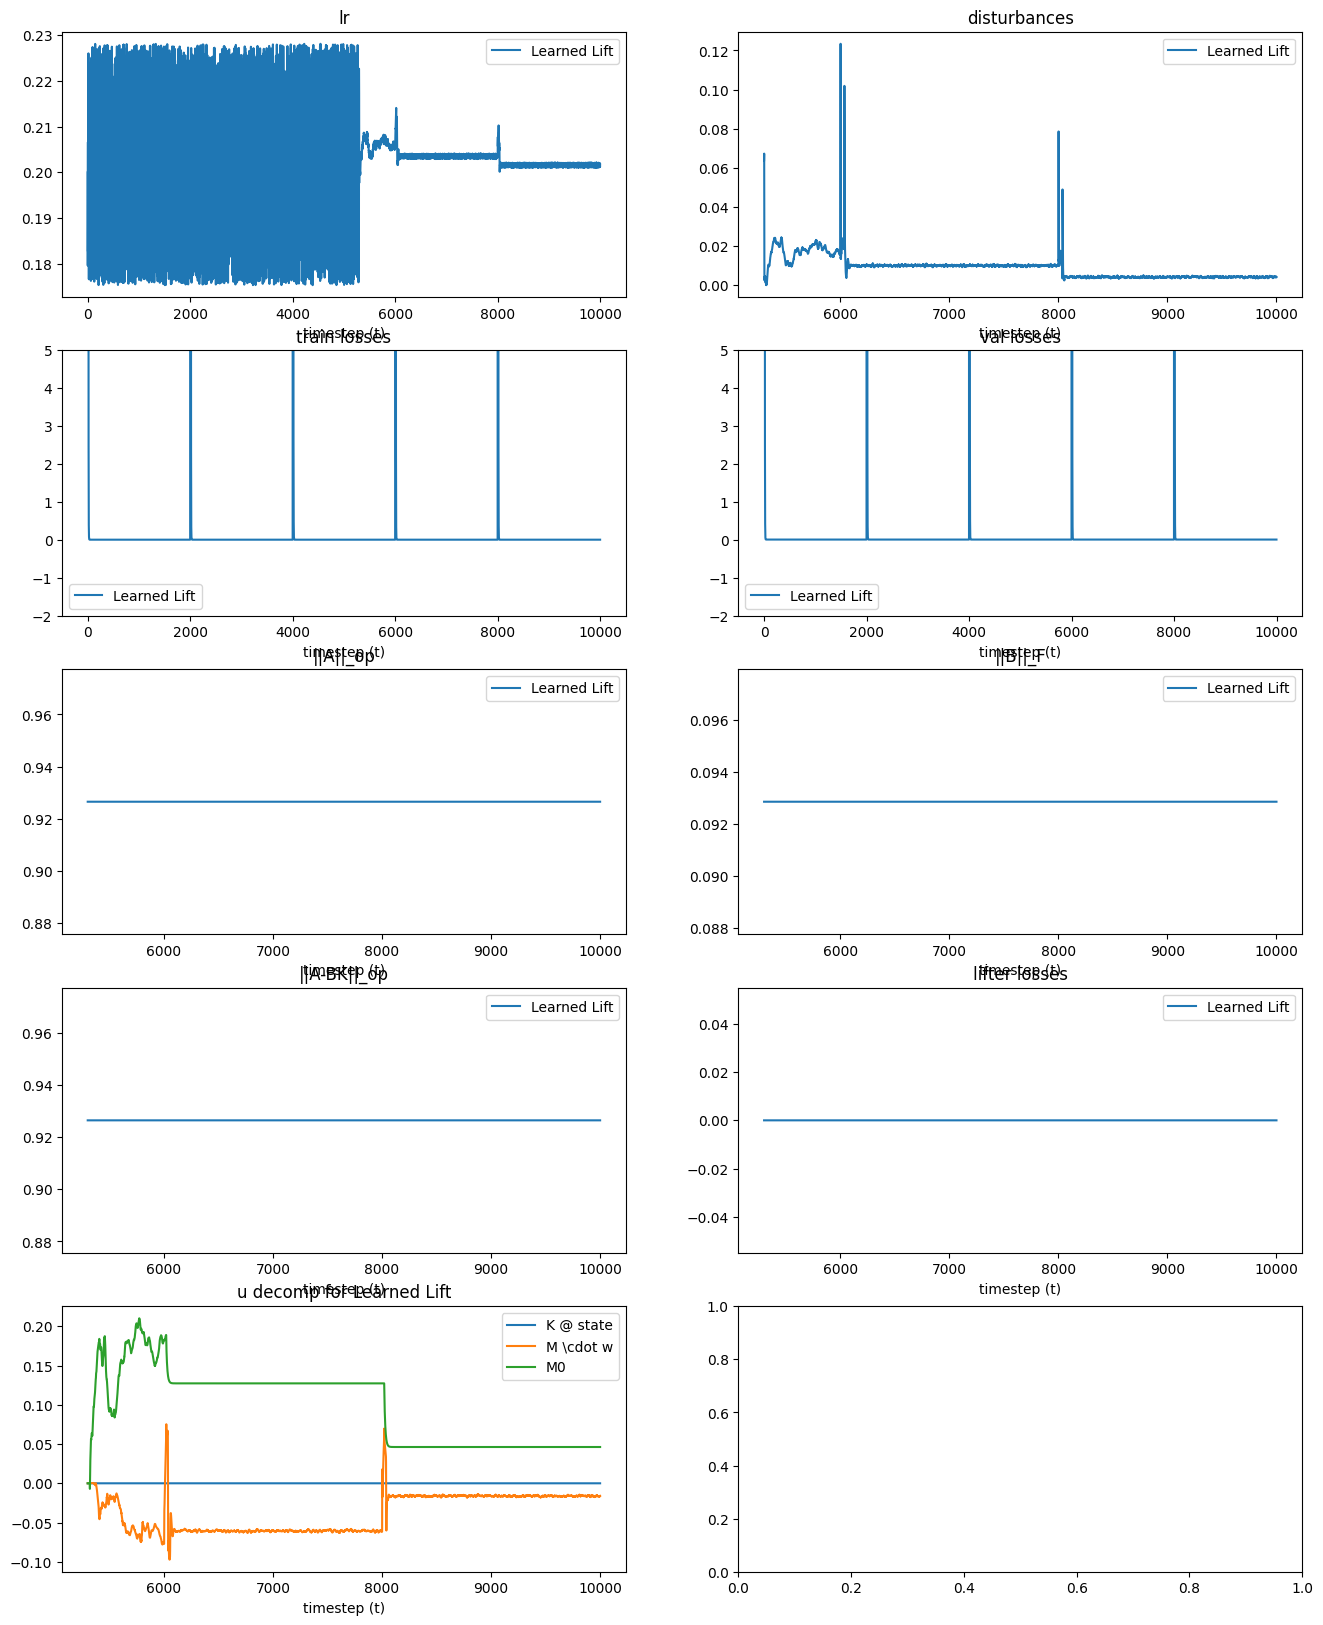

In [4]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_nn(stats)